In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os


FileNotFoundError: [WinError 3] The system cannot find the path specified: '../input'

In [22]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns

# Linear Regression to verify implementation
from sklearn.linear_model import LinearRegression

# Scipy for statistics
import scipy

# PyMC3 for Bayesian Inference
import pymc3 as pm

In [23]:
data = 'data/'
exercise = pd.read_csv(data + 'exercise.csv')
calories = pd.read_csv(data + 'calories.csv')
df = pd.merge(exercise, calories, on = 'User_ID')
df = df[df['Calories'] < 300]
df = df.reset_index()
df['Intercept'] = 1
df.head()


index   User_ID  Gender    ...      Body_Temp  Calories  Intercept
0      0  14733363    male    ...           40.8     231.0          1
1      1  14861698  female    ...           40.3      66.0          1
2      2  11179863    male    ...           38.7      26.0          1
3      3  16180408  female    ...           40.5      71.0          1
4      4  17771927  female    ...           39.8      35.0          1

[5 rows x 11 columns]

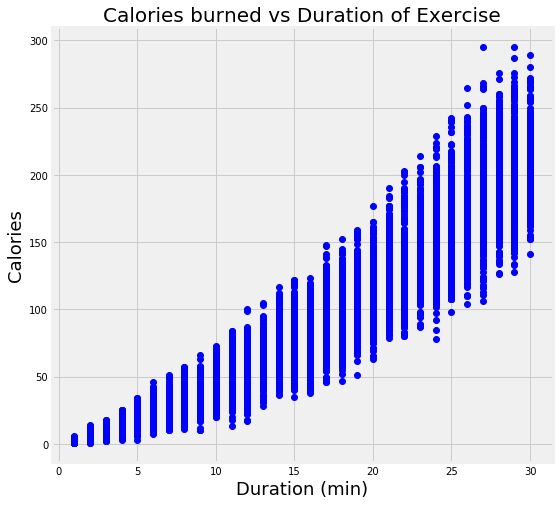

In [24]:
plt.figure(figsize=(8, 8))

plt.plot(df['Duration'], df['Calories'], 'bo');
plt.xlabel('Duration (min)', size = 18); plt.ylabel('Calories', size = 18); 
plt.title('Calories burned vs Duration of Exercise', size = 20);

In [25]:
# Create the features and response
X = df.loc[:, ['Intercept', 'Duration']]
y = df.loc[:, 'Calories']

In [26]:
X.head()

Intercept  Duration
0          1      29.0
1          1      14.0
2          1       5.0
3          1      13.0
4          1      10.0

In [27]:
y.head()

0    231.0
1     66.0
2     26.0
3     71.0
4     35.0
Name: Calories, dtype: float64

## Ordinary Least squares linear regression by hand

In [41]:
def linear_regression(X,y):
    _coeffs = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T, X)), X.T), y)
    return _coeffs

In [42]:
# Run the by hand implementation
by_hand_coefs = linear_regression(X, y)
print('Intercept calculated by hand:', by_hand_coefs[0])
print('Slope calculated by hand: ', by_hand_coefs[1])

Intercept calculated by hand: -21.82810252605084
Slope calculated by hand:  7.169783349587853


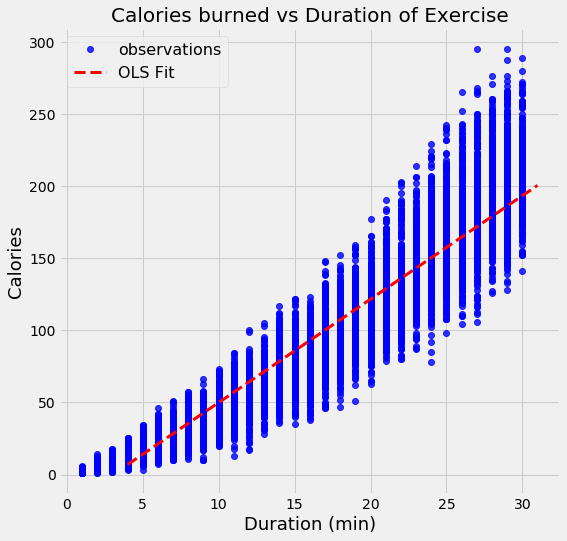

In [43]:
xs = np.linspace(4, 31, 1000)
ys = by_hand_coefs[0] + by_hand_coefs[1] * xs

plt.figure(figsize=(8, 8))

plt.plot(df['Duration'], df['Calories'], 'bo',label = 'observations', alpha = 0.8);
plt.xlabel('Duration (min)', size = 18); plt.ylabel('Calories', size = 18); 
plt.plot(xs, ys, 'r--', label = 'OLS Fit', linewidth = 3)
plt.legend(prop={'size': 16})
plt.title('Calories burned vs Duration of Exercise', size = 20);

### Prediction of Datapoint

In [31]:
print('Exercising for 15.5 minutes will burn an estimated {:.2f} calories.'.format(
    by_hand_coefs[0] + by_hand_coefs[1] * 15.5))

Exercising for 15.5 minutes will burn an estimated 89.30 calories.


### Verify with Scikit-learn Implementation

In [32]:
linear_regression = LinearRegression()
linear_regression.fit(np.array(X.Duration).reshape(-1,1),y)
print('Intercept from library:', linear_regression.intercept_)
print('Slope from library:', linear_regression.coef_[0])

Intercept from library: -21.828102526050813
Slope from library: 7.169783349587853


## Bayesian Linear Regression

### Model with 500 Observations

In [33]:
with pm.Model() as linear_model_500:
    # Intercept
    intercept = pm.Normal('Intercept', mu = 0, sd = 10)
    
    # Slope 
    slope = pm.Normal('slope', mu = 0, sd = 10)
    
    # Standard deviation
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    # Estimate of mean
    mean = intercept + slope * X.loc[0:499, 'Duration']
    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = y.values[0:500])
    
    # Sampler
    step = pm.NUTS()

    # Posterior distribution
    linear_trace_500 = pm.sample(1000, step)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, slope, Intercept]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:03<00:00, 826.16draws/s] 
The acceptance probability does not match the target. It is 0.9081439308048724, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8995421672914433, but should be close to 0.8. Try to increase the number of tuning steps.


### Model will all observations

In [34]:
with pm.Model() as linear_model:
    # Intercept
    intercept = pm.Normal('Intercept', mu = 0, sd = 10)
    
    # Slope 
    slope = pm.Normal('slope', mu = 0, sd = 10)
    
    # Standard deviation
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    # Estimate of mean
    mean = intercept + slope * X.loc[:, 'Duration']
    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = y.values)
    
    # Sampler
    step = pm.NUTS()

    # Posterior distribution
    linear_trace = pm.sample(1000, step)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, slope, Intercept]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:13<00:00, 227.23draws/s]
The acceptance probability does not match the target. It is 0.948405954953281, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9892354354458018, but should be close to 0.8. Try to increase the number of tuning steps.


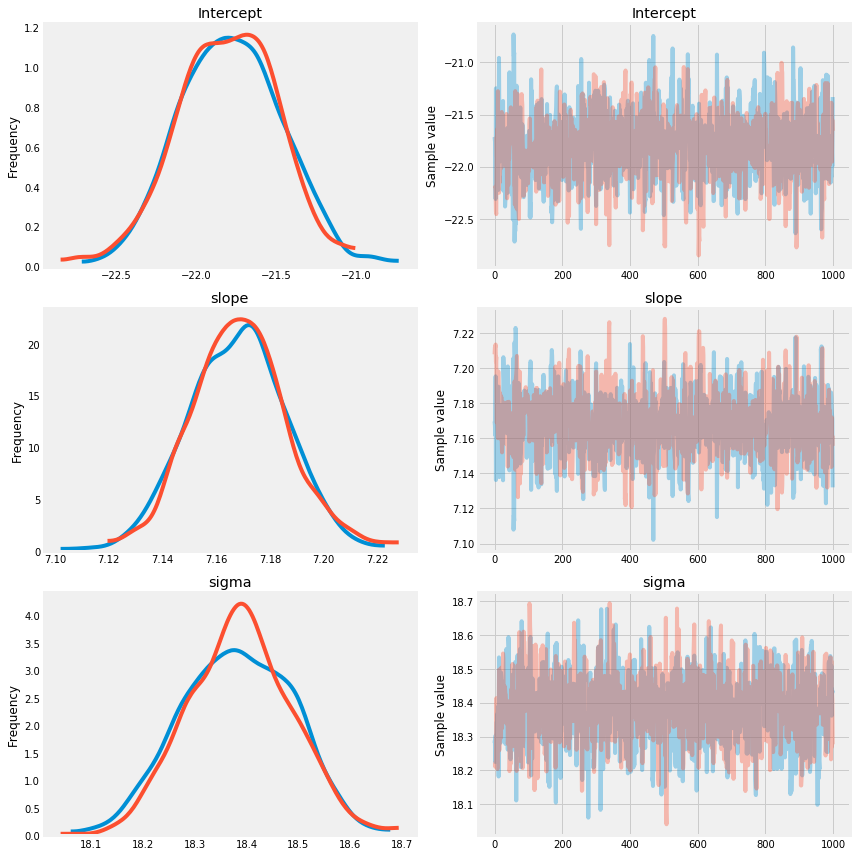

In [35]:
pm.traceplot(linear_trace, figsize = (12, 12));

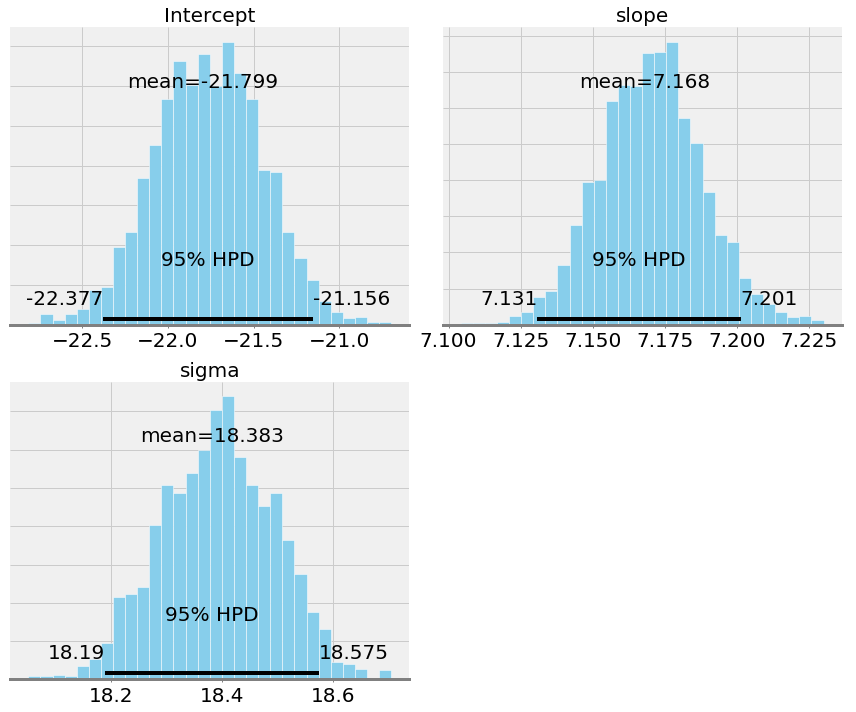

In [36]:
pm.plot_posterior(linear_trace, figsize = (12, 10), text_size = 20);

## Predictions of Response Sampled from the Posterior

### All observations

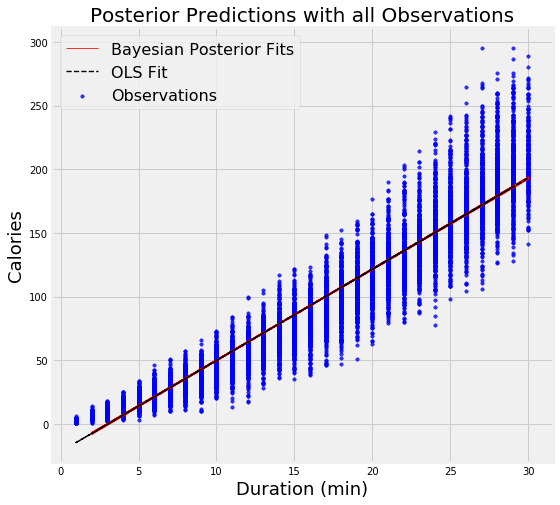

In [37]:
plt.figure(figsize = (8, 8))
pm.plot_posterior_predictive_glm(linear_trace, samples = 100, eval=np.linspace(2, 30, 100), linewidth = 1, 
                                 color = 'red', alpha = 0.8, label = 'Bayesian Posterior Fits',
                                lm = lambda x, sample: sample['Intercept'] + sample['slope'] * x);
plt.scatter(X['Duration'], y.values, s = 12, alpha = 0.8, c = 'blue', label = 'Observations')
plt.plot(X['Duration'], by_hand_coefs[0] + X['Duration'] * by_hand_coefs[1], 'k--', label = 'OLS Fit', linewidth = 1.4)
plt.title('Posterior Predictions with all Observations', size = 20); plt.xlabel('Duration (min)', size = 18);
plt.ylabel('Calories', size = 18);
plt.legend(prop={'size': 16});

### Limited Observations

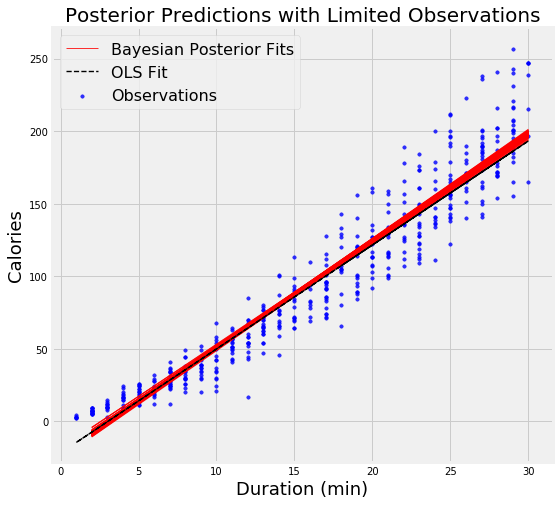

In [38]:
plt.figure(figsize = (8, 8))
pm.plot_posterior_predictive_glm(linear_trace_500, samples = 100, eval=np.linspace(2, 30, 100), linewidth = 1, 
                                 color = 'red', alpha = 0.8, label = 'Bayesian Posterior Fits',
                                lm = lambda x, sample: sample['Intercept'] + sample['slope'] * x);
plt.scatter(X['Duration'][:500], y.values[:500], s = 12, alpha = 0.8, c = 'blue', label = 'Observations')
plt.plot(X['Duration'], by_hand_coefs[0] + X['Duration'] * by_hand_coefs[1], 'k--', label = 'OLS Fit', linewidth = 1.4)
plt.title('Posterior Predictions with Limited Observations', size = 20); plt.xlabel('Duration (min)', size = 18);
plt.ylabel('Calories', size = 18);
plt.legend(prop={'size': 16});

## Specific Prediction for One Datapoint

In [39]:
bayes_prediction = linear_trace['Intercept'] + linear_trace['slope'] * 15.5

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


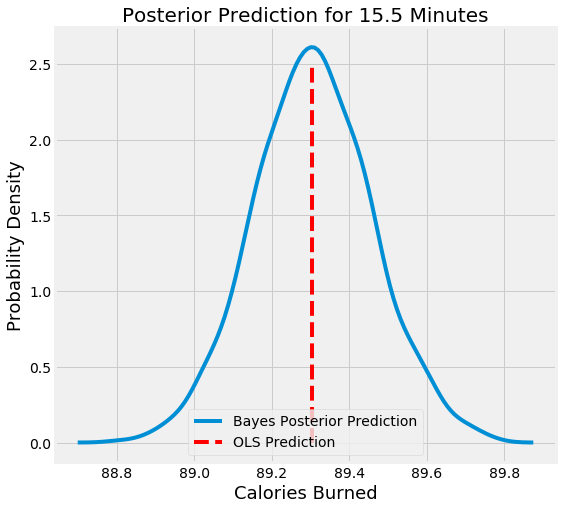

In [40]:
plt.figure(figsize = (8, 8))
plt.style.use('fivethirtyeight')
sns.kdeplot(bayes_prediction, label = 'Bayes Posterior Prediction')
plt.vlines(x = by_hand_coefs[0] + by_hand_coefs[1] * 15.5, 
           ymin = 0, ymax = 2.5, 
           label = 'OLS Prediction',
          colors = 'red', linestyles='--')
plt.legend();
plt.xlabel('Calories Burned', size = 18), plt.ylabel('Probability Density', size = 18);
plt.title('Posterior Prediction for 15.5 Minutes', size = 20);